# Guided Project: Analyzing NYC High School Data

## Read in the data

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv", # Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
    "class_size.csv", # Information on class size for each school
    "demographics.csv", # Demographic information for each school
    "graduation.csv", # The percentage of students who graduated, and other outcome information
    "hs_directory.csv", # High school attributes 
    "sat_results.csv" # SAT scores for each high school in New York City
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

survey = survey[survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]
data["hs_directory"]["DBN"].head()

0    17K548
1    09X543
2    09X327
3    02M280
4    28Q680
Name: DBN, dtype: object

In [4]:
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].astype(str).str.zfill(2)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
data["class_size"]["DBN"].head()

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object

## Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
data["sat_results"][cols] = data["sat_results"][cols].apply(pd.to_numeric, errors='coerce')
data['sat_results']['sat_score'] = data['sat_results'][cols].sum(axis=1, skipna=False)
data['sat_results'][cols + ['sat_score']].head()

,SAT Math Avg. Score,SAT Critical Reading Avg. Score,SAT Writing Avg. Score,sat_score
0,404.0,355.0,363.0,1122.0
1,423.0,383.0,366.0,1172.0
2,402.0,377.0,370.0,1149.0
3,401.0,414.0,359.0,1174.0
4,433.0,390.0,384.0,1207.0


In [6]:
(data['sat_results']['sat_score'] == 0).sum()

0

In [7]:
pd.options.display.max_colwidth = 100
coord = data["hs_directory"]["Location 1"].str.extract(r'\((.+), (.+)\)', expand=False)
data["hs_directory"][['lat', 'lon']] = coord.apply(pd.to_numeric, errors='coerce')
data["hs_directory"][["Location 1", 'lat', 'lon']].head()

,Location 1,lat,lon
0,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67029890700047, -73.96164787599963)",40.670299,-73.961648
1,"1110 Boston Road\nBronx, NY 10456\n(40.8276026690005, -73.90447525699966)",40.827603,-73.904475
2,"1501 Jerome Avenue\nBronx, NY 10452\n(40.842414068000494, -73.91616158599965)",40.842414,-73.916162
3,"411 Pearl Street\nNew York, NY 10038\n(40.71067947100045, -74.00080702099967)",40.710679,-74.000807
4,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40.718810094000446, -73.80650045499965)",40.718810,-73.806500


## Condense datasets

In [8]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size = class_size.reset_index()
data["class_size_grouped"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [9]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
data["ap_2010"][cols] = data["ap_2010"][cols].apply(pd.to_numeric, errors='coerce')
data["ap_2010"][cols].head()

,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,39.0,49.0,10.0
1,19.0,21.0,NaN
2,24.0,26.0,24.0
3,255.0,377.0,191.0
4,NaN,NaN,NaN


## Combine the datasets

In [10]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

combined = combined.merge(data["class_size_grouped"], on="DBN", how="inner")
combined = combined.merge(data["demographics"], on="DBN", how="inner")
combined = combined.merge(data["survey"], on="DBN", how="inner")
combined = combined.merge(data["hs_directory"], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.71376394700047, -73.98526003999967)",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.7123318510005, -73.98479662499966)",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.729782687000466, -73.98304144099967)",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.720569079000484, -73.98567269099965)",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND MATH HIGH SCHOOL",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.718725451000466, -73.97942638599966)",40.718725,-73.979426


## Add a school district column for mapping

In [11]:
combined["school_dist"] = combined["DBN"].str[:2]
combined["school_dist"].value_counts()

02    48
10    22
09    20
11    15
14    14
17    14
07    13
13    13
24    13
19    12
03    12
12    12
08    11
21    11
28    11
18    11
27    10
06    10
31    10
15     9
30     9
25     8
29     8
04     7
05     7
32     6
01     6
20     5
26     5
16     4
22     4
23     3
Name: school_dist, dtype: int64

## Find correlations

In [12]:
correlations = combined.corr()
correlations = correlations["sat_score"]

In [13]:
correlations.sort_values(ascending=False).head(30)

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num                              0.388631
AVERAGE CLASS SIZE                      0.381014
total_enrollment                        0.367857
NUMBER OF SECTIONS                      0.362673
aca_s_11                                0.339435
saf_s_11            

In [14]:
correlations.sort_values().head(30)

frl_percent       -0.722225
sped_percent      -0.448170
ell_percent       -0.398750
hispanic_per      -0.396985
black_per         -0.284139
ell_num           -0.153778
lon               -0.132222
lat               -0.121029
com_p_11          -0.115073
male_per          -0.112062
zip               -0.063977
rr_t              -0.023386
eng_p_11           0.020254
hispanic_num       0.025744
black_num          0.027979
sped_num           0.034933
aca_p_11           0.035155
eng_t_11           0.036906
CSD                0.042948
rr_p               0.047925
com_tot_11         0.077310
com_t_11           0.082419
eng_tot_11         0.100102
female_per         0.112108
number_programs    0.117012
saf_p_11           0.122913
aca_t_11           0.132348
com_s_11           0.187370
aca_tot_11         0.190966
eng_s_11           0.213822
Name: sat_score, dtype: float64

## Plotting survey correlations

In [15]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
if 'DBN' in survey_fields: survey_fields.remove("DBN")

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

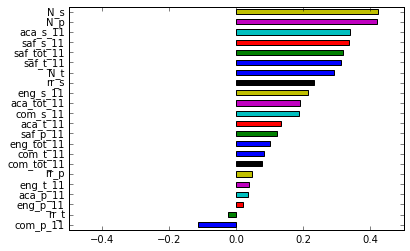

In [17]:
correlations[survey_fields].sort_values().plot(kind='barh', xlim=(-0.5,0.5))

The highest correlations appears on the following columns:
* `N_s`, `N_p` and `N_t` stands for number of students, parents and teachers respondents.
* `aca_s_11` for academic expectations based on student responses. This means that students are more accurate in assessing their own skills.
* `saf` high safety and respect score means higher `sat_score`. Safety first.
* `rr_s` student response rate also correlates with `sat_score`.

## Exploring Safety and SAT Scores

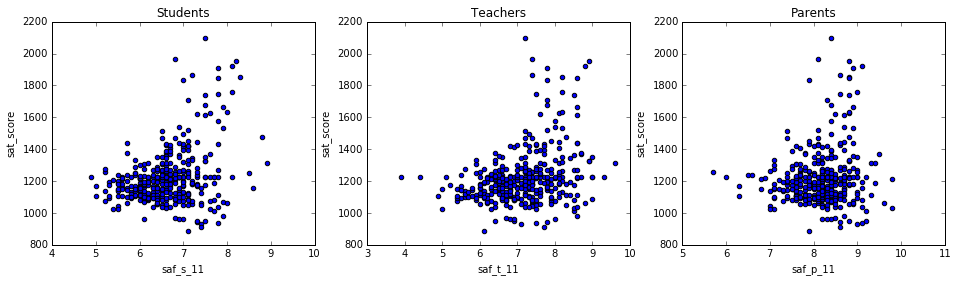

In [18]:
fig, _ = plt.subplots(1, 3, figsize=(16,4))
combined.plot(kind='scatter', x="saf_s_11", y="sat_score", title='Students', ax=fig.axes[0])
combined.plot(kind='scatter', x="saf_t_11", y="sat_score", title='Teachers', ax=fig.axes[1])
combined.plot(kind='scatter', x="saf_p_11", y="sat_score", title='Parents', ax=fig.axes[2])

There is a correlation between `safety and respect score` and `sat score`, but not that strong. No school with safety score below ~7 have SAT score above ~1500 points. Hovewer, there are some schools with high safety score and low SAT scores.

In [19]:
combined.pivot_table(index='boro', values=['saf_s_11', 'saf_t_11', 'saf_p_11'])

,saf_p_11,saf_s_11,saf_t_11
boro,,,
Bronx,8.346237,6.606577,7.026882
Brooklyn,8.036792,6.370755,6.985849
Manhattan,8.288889,6.831370,7.287778
Queens,8.098437,6.721875,7.365625
Staten Island,7.800000,6.530000,7.210000


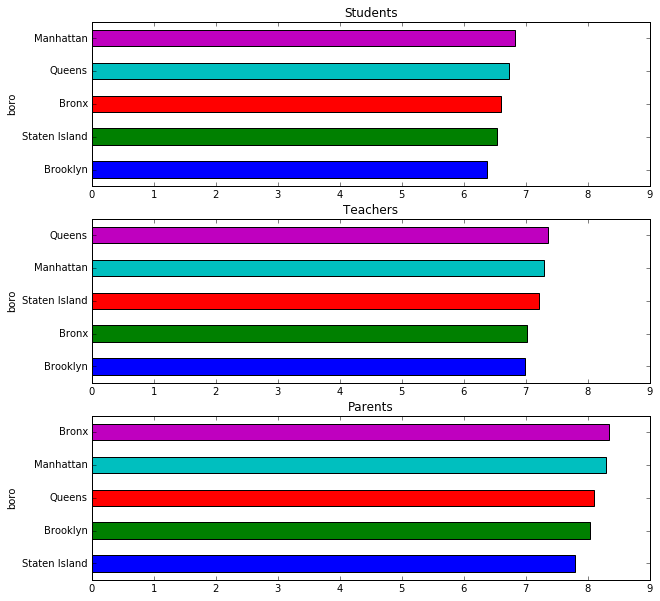

In [20]:
boro_saf = combined.pivot_table(index='boro', values=['saf_s_11', 'saf_t_11', 'saf_p_11'])
fig, _ = plt.subplots(3, 1, figsize=(10,10))
boro_saf['saf_s_11'].sort_values().plot(kind='barh', title='Students', xlim=(0,9), ax=fig.axes[0])
boro_saf['saf_t_11'].sort_values().plot(kind='barh', title='Teachers', xlim=(0,9), ax=fig.axes[1])
boro_saf['saf_p_11'].sort_values().plot(kind='barh', title='Parents', xlim=(0,9), ax=fig.axes[2])

According to the students surveys Manhattan tend to have 1st place in the Safety rating, and 2nd place based on Teachers and Parents surveys. All three groups have different opinion about other boroughs.

## Exploring Race and SAT Scores

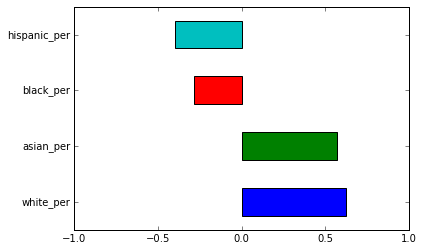

In [21]:
correlations[['white_per', 'asian_per', 'black_per', 'hispanic_per']].plot(kind='barh', xlim=(-1,1))

Higher percentage of asian and white students correlates positively with SAT score. Opposite happens with hispanic and black students. Different factors may apply, such as lack of funding for example.

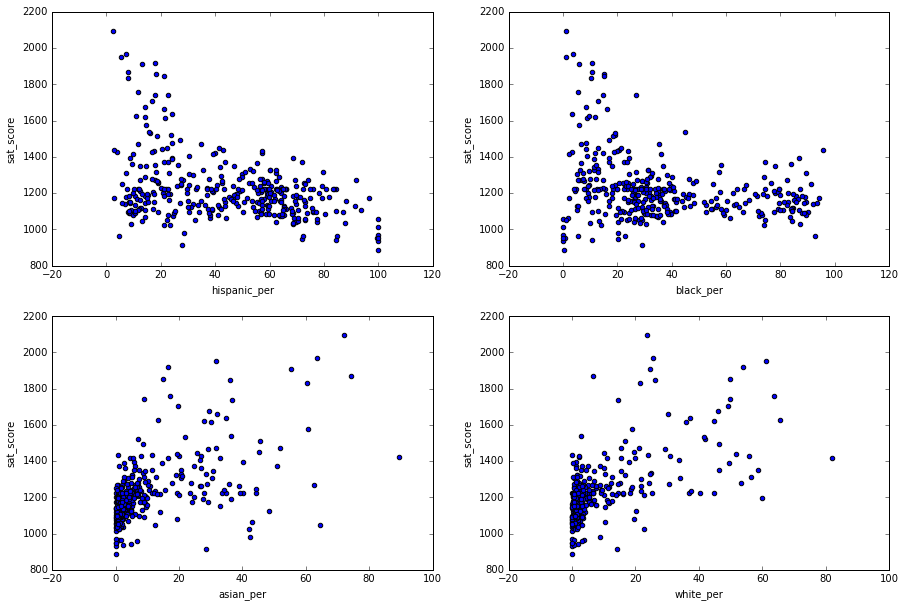

In [22]:
fig, _ = plt.subplots(2, 2, figsize=(15,10))
combined.plot(kind='scatter', x='hispanic_per', y='sat_score', ax=fig.axes[0])
combined.plot(kind='scatter', x='black_per', y='sat_score', ax=fig.axes[1])
combined.plot(kind='scatter', x='asian_per', y='sat_score', ax=fig.axes[2])
combined.plot(kind='scatter', x='white_per', y='sat_score', ax=fig.axes[3])

In [23]:
combined.loc[combined['hispanic_per'] > 95, 'SCHOOL NAME']

44                                MANHATTAN BRIDGES HIGH SCHOOL
82             WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS
125                         ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                       INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176            PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                                   MULTICULTURAL HIGH SCHOOL
286                      PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [24]:
combined.loc[(combined['hispanic_per'] < 95) & (combined['sat_score'] > 1000), 'SCHOOL NAME'].head(10)

0                     HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES
1                               UNIVERSITY NEIGHBORHOOD HIGH SCHOOL
2                                        EAST SIDE COMMUNITY SCHOOL
3                                           MARTA VALLE HIGH SCHOOL
4    NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND MATH HIGH SCHOOL
5                                    BARD HIGH SCHOOL EARLY COLLEGE
6        47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECONDARY SCHOOL
7                                      FOOD AND FINANCE HIGH SCHOOL
8                                              ESSEX STREET ACADEMY
9                             HIGH SCHOOL OF HOSPITALITY MANAGEMENT
Name: SCHOOL NAME, dtype: object

## Exploring Gender and SAT Scores

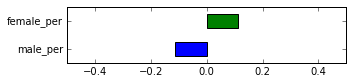

In [25]:
correlations[['male_per', 'female_per']].plot(kind='barh', xlim=(-0.5,0.5), figsize=(5,1))

Both male and female percentages have weak correlations with SAT Score. While SAT Score positively correlates with high percentage of female, it negatively correlates with high percentage of males.

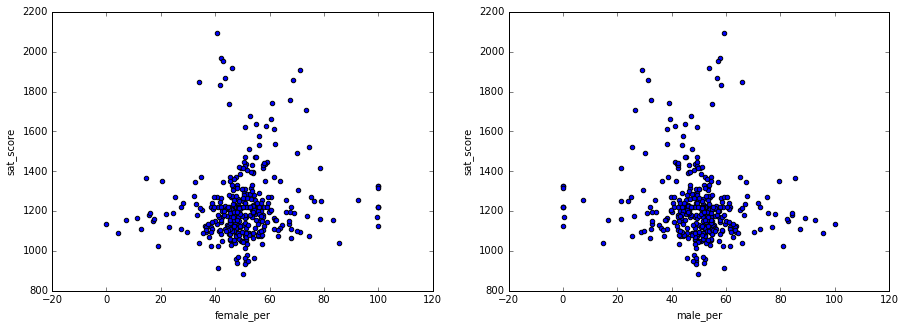

In [26]:
fig, _ = plt.subplots(1, 2, figsize=(15,5))
combined.plot(kind='scatter', x='female_per', y='sat_score', ax=fig.axes[0])
combined.plot(kind='scatter', x='male_per', y='sat_score', ax=fig.axes[1])

Corelation is too weak to draw a conclusion.

In [27]:
combined.loc[(combined['female_per'] < 60) & (combined['sat_score'] > 1700), 'SCHOOL NAME']

37                                                   STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGINEERING AT CITY COLLEGE
151                                            BRONX HIGH SCHOOL OF SCIENCE
155                       HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                                          BROOKLYN TECHNICAL HIGH SCHOOL
198                                              BROOKLYN LATIN SCHOOL, THE
327                     QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE
356                                     STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## Exploring AP Scores vs. SAT Scores

0.05717081390766967


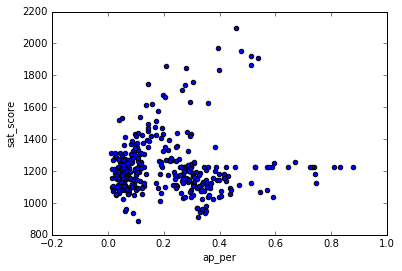

In [42]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
print(combined.corr().loc['sat_score', 'ap_per'])
combined.plot(kind='scatter', x='ap_per', y='sat_score')

Correlation between AP scores and SAT scores is weak and needs deeper exploration. There is an uprising trend with AP scores < 0.6, and some outliers with AP scores > 0.6

In [ ]:
dd